In [1]:
from __future__ import annotations

import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from edpyt.dmft import DMFT, Converged, Gfimp
from edpyt.nano_dmft import Gfimp as nanoGfimp
from edpyt.nano_dmft import Gfloc
from mpi4py import MPI
from qtpyt.base.selfenergy import DataSelfEnergy as BaseDataSelfEnergy
from qtpyt.block_tridiag import greenfunction
from qtpyt.continued_fraction import get_ao_charge
from qtpyt.projector import ProjectedGreenFunction, expand
from scipy.optimize import root

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

[anooja-ThinkPad-X1-Carbon-Gen-11:24857] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [2]:
class DataSelfEnergy(BaseDataSelfEnergy):
    """Wrapper"""

    def retarded(self, energy):
        return expand(S_molecule, super().retarded(energy), idx_molecule)


def load(filename):
    return DataSelfEnergy(energies, np.load(filename))


def distance(delta):
    global delta_prev
    delta_prev[:] = delta
    return dmft.distance(delta)


def save_sigma(sigma_diag, outputfile, npsin):
    L, ne = sigma_diag.shape
    sigma = np.zeros((ne, L, L), complex)

    def save(spin):
        for diag, mat in zip(sigma_diag.T, sigma):
            mat.flat[:: (L + 1)] = diag
        np.save(outputfile, sigma)

    for spin in range(nspin):
        save(spin)


In [3]:
nbaths = 4
U = 0.5
adjust_mu = True
use_double_counting = True
tol = 1e-4
max_iter = 1000
alpha = 0.0
nspin = 1
eta = 3e-2
data_folder = "../../output"
output_folder = "../../output/toy_model2"

# Define output folder based on parameters
dc_str = "with_dc" if use_double_counting else "without_dc"
mu_str = "adjust_mu" if adjust_mu else "no_adjust_mu"
output_folder_combination = f"{output_folder}/nbaths_{nbaths}_U_{U}_DC_{dc_str}_{mu_str}"
os.makedirs(output_folder_combination, exist_ok=True)

occupancy_goal = np.load(f"{data_folder}/occupancies.npy")
len_active = 9
energies = np.arange(-10, 10, 0.01)
z_ret = energies + 1.0j * eta

H_active = np.load(f"{data_folder}/hamiltonian.npy").real
index_active_region = np.load(f"{data_folder}/index_active_region.npy")
beta = 1000
ne = 3000
z_mats = 1.0j * (2 * np.arange(ne) + 1) * np.pi / beta

HybMats = lambda z: 0.0
S_active = np.eye(len_active)
idx_neq = np.arange(len_active)
idx_inv = np.arange(len_active)

V = np.eye(len_active) * U


In [4]:
# Apply double counting correction if specified
double_counting = (
    np.diag(V.diagonal() * (occupancy_goal - 0.5))
    if use_double_counting
    else np.zeros((len_active, len_active))
)
gfloc = Gfloc(H_active - double_counting, np.eye(len_active), HybMats, idx_neq, idx_inv)

nimp = gfloc.idx_neq.size
gfimp = [Gfimp(nbaths, z_mats.size, V[i, i], beta) for i in range(nimp)]
gfimp = nanoGfimp(gfimp)

occupancy_goal_ = occupancy_goal[gfloc.idx_neq]

# Initialize DMFT with adjust_mu parameter
dmft = DMFT(
    gfimp,
    gfloc,
    occupancy_goal_,
    max_iter=max_iter,
    tol=tol,
    adjust_mu=adjust_mu,
    alpha=alpha,
    egrid=z_ret,
    store_iterations=True,
    iter_filename=f"{output_folder_combination}/dmft_iterations.h5",
)

Sigma = lambda z: np.zeros((nimp, z.size), complex)
delta = dmft.initialize(V.diagonal().mean(), Sigma, mu=0.0)
delta_prev = delta.copy()


In [5]:
np.sum(occupancy_goal)

11.701726853426146

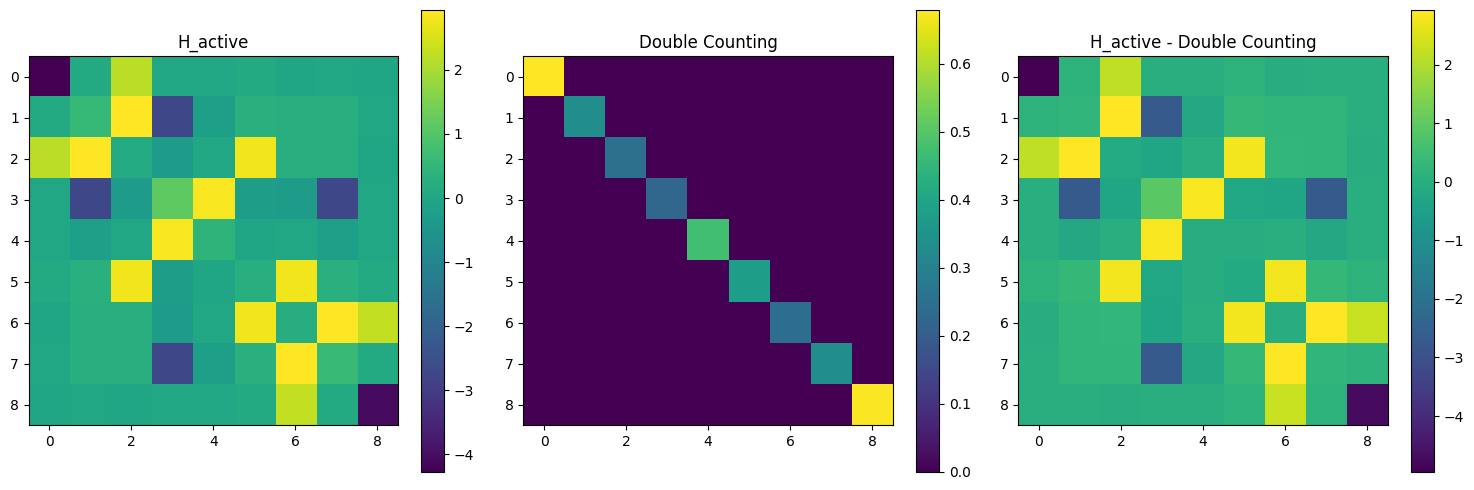

In [6]:
difference = H_active - double_counting

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first array
im1 = axes[0].imshow(H_active)
axes[0].set_title("H_active")
fig.colorbar(im1, ax=axes[0])

# Plot the second array
im2 = axes[1].imshow(double_counting)
axes[1].set_title("Double Counting")
fig.colorbar(im2, ax=axes[1])

# Plot the difference
im3 = axes[2].imshow(difference)
axes[2].set_title("H_active - Double Counting")
fig.colorbar(im3, ax=axes[2])

# Show the plots
plt.tight_layout()
plt.show()


In [7]:
try:
    root(distance, delta_prev, method="broyden1")
except Converged:
    pass


Iteration :  0
gf integrate 0.0029374150394496645
occupancy 11.701726853426146
distance -11.698789438386697
gf integrate 17.996821196765804
occupancy 11.701726853426146
distance 6.295094343339658
gf integrate 15.999370083966381
occupancy 11.701726853426146
distance 4.297643230540235
gf integrate 0.002402875807961502
occupancy 11.701726853426146
distance -11.699323977618185
gf integrate 12.000802647406921
occupancy 11.701726853426146
distance 0.29907579398077466
gf integrate 12.000685216890378
occupancy 11.701726853426146
distance 0.2989583634642319
gf integrate 8.001538427215339
occupancy 11.701726853426146
distance -3.700188426210808
gf integrate 12.00053736334117
occupancy 11.701726853426146
distance 0.29881050991502356
gf integrate 10.00183573850541
occupancy 11.701726853426146
distance -1.699891114920737
gf integrate 12.000409604017591
occupancy 11.701726853426146
distance 0.29868275059144445
gf integrate 12.000074332658212
occupancy 11.701726853426146
distance 0.2983474792320653
g

In [ ]:
# Save results for this combination
np.save(f"{output_folder_combination}/dmft_delta.npy", delta_prev)
with open(f"{output_folder_combination}/mu.txt", "w") as mu_file:
    mu_file.write(str(gfloc.mu))

_Sigma = lambda z: -gfloc.mu + gfloc.Sigma(z)[idx_inv]
dmft_sigma_file = f"{output_folder_combination}/dmft_sigma.npy"
save_sigma(_Sigma(z_ret), dmft_sigma_file, nspin)

gfloc_data = gfloc(z_ret)
np.save(f"{output_folder_combination}/dmft_gfloc.npy", gfloc_data)

# Compute orbital occupancy before and after including DMFT self-energy
self_energy = np.load(f"{data_folder}/self_energy.npy", allow_pickle=True)
with open(f"{data_folder}/hs_list_ii.pkl", "rb") as f:
    hs_list_ii = pickle.load(f)
with open(f"{data_folder}/hs_list_ij.pkl", "rb") as f:
    hs_list_ij = pickle.load(f)

gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [(0, self_energy[0]), (len(hs_list_ii) - 1, self_energy[1])],
    solver="dyson",
    eta=eta,
)
gfp = ProjectedGreenFunction(gf, index_active_region)
charge_dft = get_ao_charge(gfp)

nodes = [0, 810, 1116, 1278, 1584, 2394]
imb = 2  # index of molecule block from the nodes list
S_molecule = hs_list_ii[imb][1]  # overlap of molecule
idx_molecule = (
    index_active_region - nodes[imb]
)  # indices of active region w.r.t molecule

np.save(f"{output_folder_combination}/charge_per_orbital_dft.npy", charge_dft)

dmft_sigma = load(dmft_sigma_file)
self_energy[2] = dmft_sigma
gf.selfenergies.append((imb, self_energy[2]))

gfp_dmft = ProjectedGreenFunction(gf, index_active_region)
charge_dmft = get_ao_charge(gfp_dmft)
np.save(f"{output_folder_combination}/charge_per_orbital_dmft.npy", charge_dmft)
